In [1]:
import numpy as np
import bms_env_new
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random




from utils import *


# Import the necessary libraries
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env

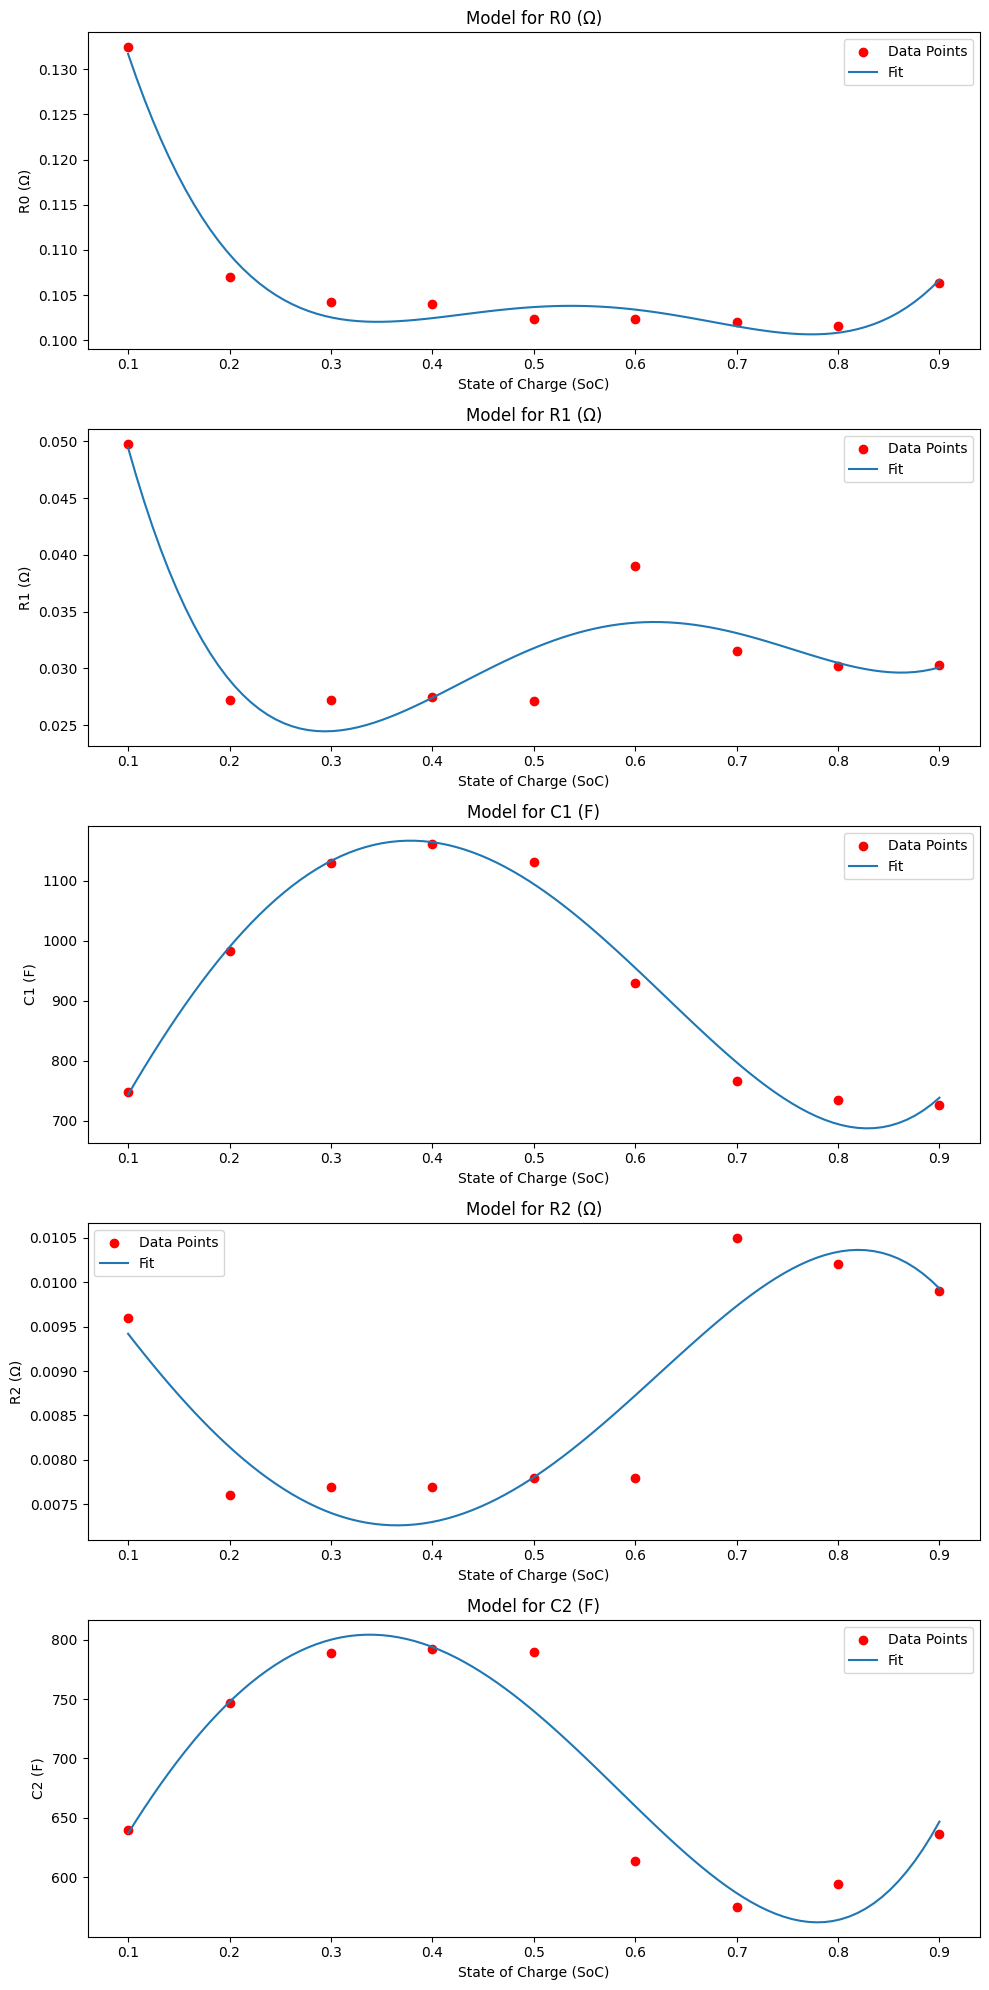

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Data from the image
data = np.array([
    [0.9, 0.1063, 0.0303, 726.32, 0.0099, 636.78],
    [0.8, 0.1016, 0.0302, 734.10, 0.0102, 594.41],
    [0.7, 0.1020, 0.0315, 766.53, 0.0105, 575.44],
    [0.6, 0.1023, 0.0390, 929.76, 0.0078, 613.48],
    [0.5, 0.1024, 0.0271, 1131.40, 0.0078, 789.73],
    [0.4, 0.1040, 0.0275, 1161.67, 0.0077, 791.77],
    [0.3, 0.1042, 0.0272, 1128.74, 0.0077, 788.39],
    [0.2, 0.1070, 0.0272, 982.50, 0.0076, 746.24],
    [0.1, 0.1325, 0.0498, 747.54, 0.0096, 639.61]
])

# Splitting the data
X = data[:, 0].reshape(-1, 1)  # SoC values
Y = data[:, 1:]  # Remaining columns

# Transform input data to include quadratic terms
poly = PolynomialFeatures(degree= 4)
X_poly = poly.fit_transform(X)

# Train a model for each output
models = []
for i in range(Y.shape[1]):
    model = LinearRegression()
    model.fit(X_poly, Y[:, i])
    models.append(model)

# Generate a range of SoC values for prediction
X_plot = np.linspace(0.1, 0.9, 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
output_labels = ['R0 (Ω)', 'R1 (Ω)', 'C1 (F)', 'R2 (Ω)', 'C2 (F)']

for i, ax in enumerate(axs):
    predictions = models[i].predict(X_plot_poly)
    ax.scatter(X, Y[:, i], color='red', label='Data Points')
    ax.plot(X_plot, predictions, label='Fit')
    ax.set_title(f'Model for {output_labels[i]}')
    ax.set_xlabel('State of Charge (SoC)')
    ax.set_ylabel(output_labels[i])
    ax.legend()

plt.tight_layout()
plt.show()

In [3]:
num_cells = 10
bms = bms_env_new.BMSenv(num_cells= num_cells, k_tanh_params= np.random.uniform(0, 0.12, num_cells),
                          Q_cells =np.random.uniform(3., 4. ,num_cells), w_reward=1_000, var_weight= 0.0, max_min_weight= 1., switch_weight= 0.)    




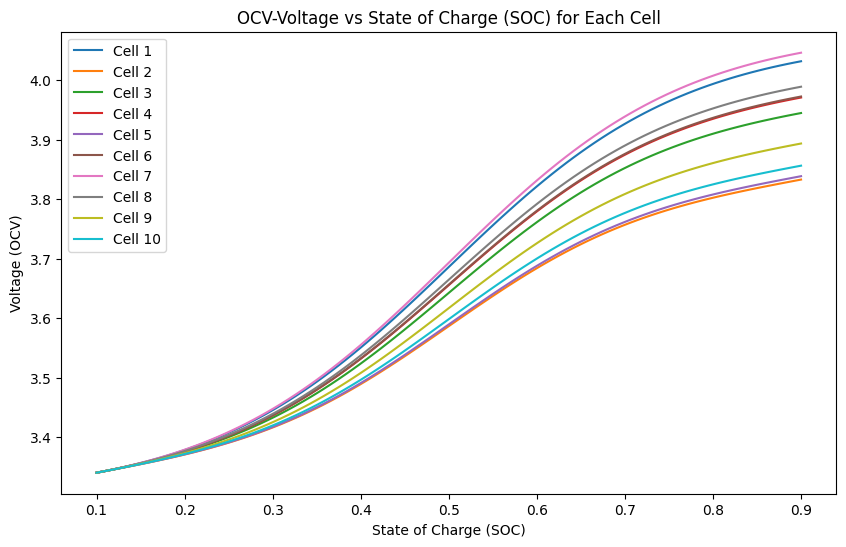

In [4]:
plot_voltage_vs_soc(bms)

In [5]:
T = 20_000

# Always disconected (All the batteries stay still)

In [152]:
bms.reset(seed = 0)
states_soc_1 = [bms.state[:num_cells]]
states_voltage_1 = [bms.state[num_cells:]]
actions_1 = []
rewards_1 = []
dones_1 = [False]

while not dones_1[-1] and len(states_soc_1) < T:
    action = [0 for _ in range(num_cells)]
   
    
    actions_1.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_1.append(state[:num_cells])
    states_voltage_1.append(state[num_cells:])
    rewards_1.append(reward)
    dones_1.append(done)

print(f"Sum of rewards: {np.sum(rewards_1)}")

charge_end_1 = len(states_soc_1)
mean_capacity_1 = np.mean(states_soc_1[-1])
min_capacity_1 = np.min(states_soc_1[-1])
actions_1 = np.array(actions_1)
stds_1 = np.std(states_soc_1[-1])
mismatches_1 = sum([np.sum(actions_1[i] != actions_1[i+1]) for i in range(len(actions_1) - 1)])




while states_soc_1[-1].min() > 0.1:
    bms.discharge()
    states_soc_1.append(bms.state[:num_cells])
    states_voltage_1.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_1}")
print(f"Length of discharge: {len(states_soc_1) - charge_end_1}")
print(f"Total length: {len(states_soc_1)}")
print(f"Mean capacity: {np.round(mean_capacity_1, 3)}")
print(f"Min capacity: {np.round(min_capacity_1, 3)}")
print(f"Number of mismatches: {mismatches_1}")

data = {
    "Length of charge": [charge_end_1],
    "Length of discharge": [len(states_soc_1) - charge_end_1],
    "Total length": [len(states_soc_1)],
    "Standard Deviation": [stds_1],
    "Mean capacity": [np.round(mean_capacity_1, 3)],
    "Min capacity": [np.round(min_capacity_1, 3)],
    "Number of switches": [mismatches_1]
}

df = pd.DataFrame(data)
np.round(df, 4).T


Sum of rewards: 18.666531093790468
Length of charge: 98
Length of discharge: 111
Total length: 209
Mean capacity: 0.767
Min capacity: 0.656
Number of mismatches: 0


,0
Length of charge,98.0000
Length of discharge,111.0000
Total length,209.0000
Standard Deviation,0.0742
Mean capacity,0.7670
Min capacity,0.6560
Number of switches,0.0000


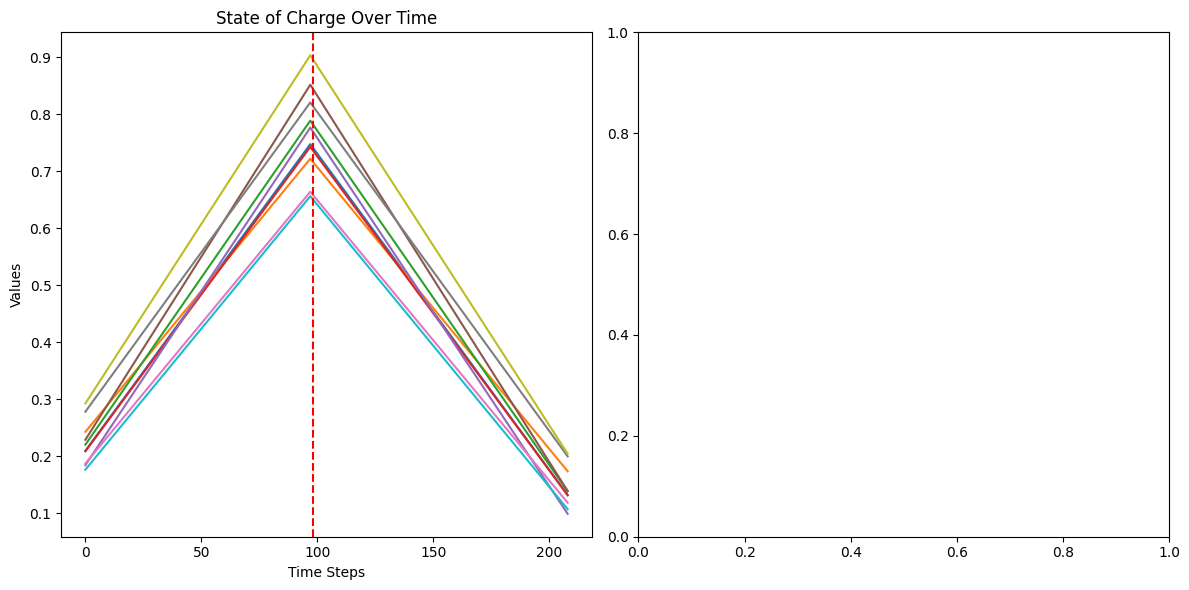

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_1, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_1, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_1, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_1, color='r', linestyle='--', label='Charge End')


plt.tight_layout()  # Adjust layout to prevent overlap


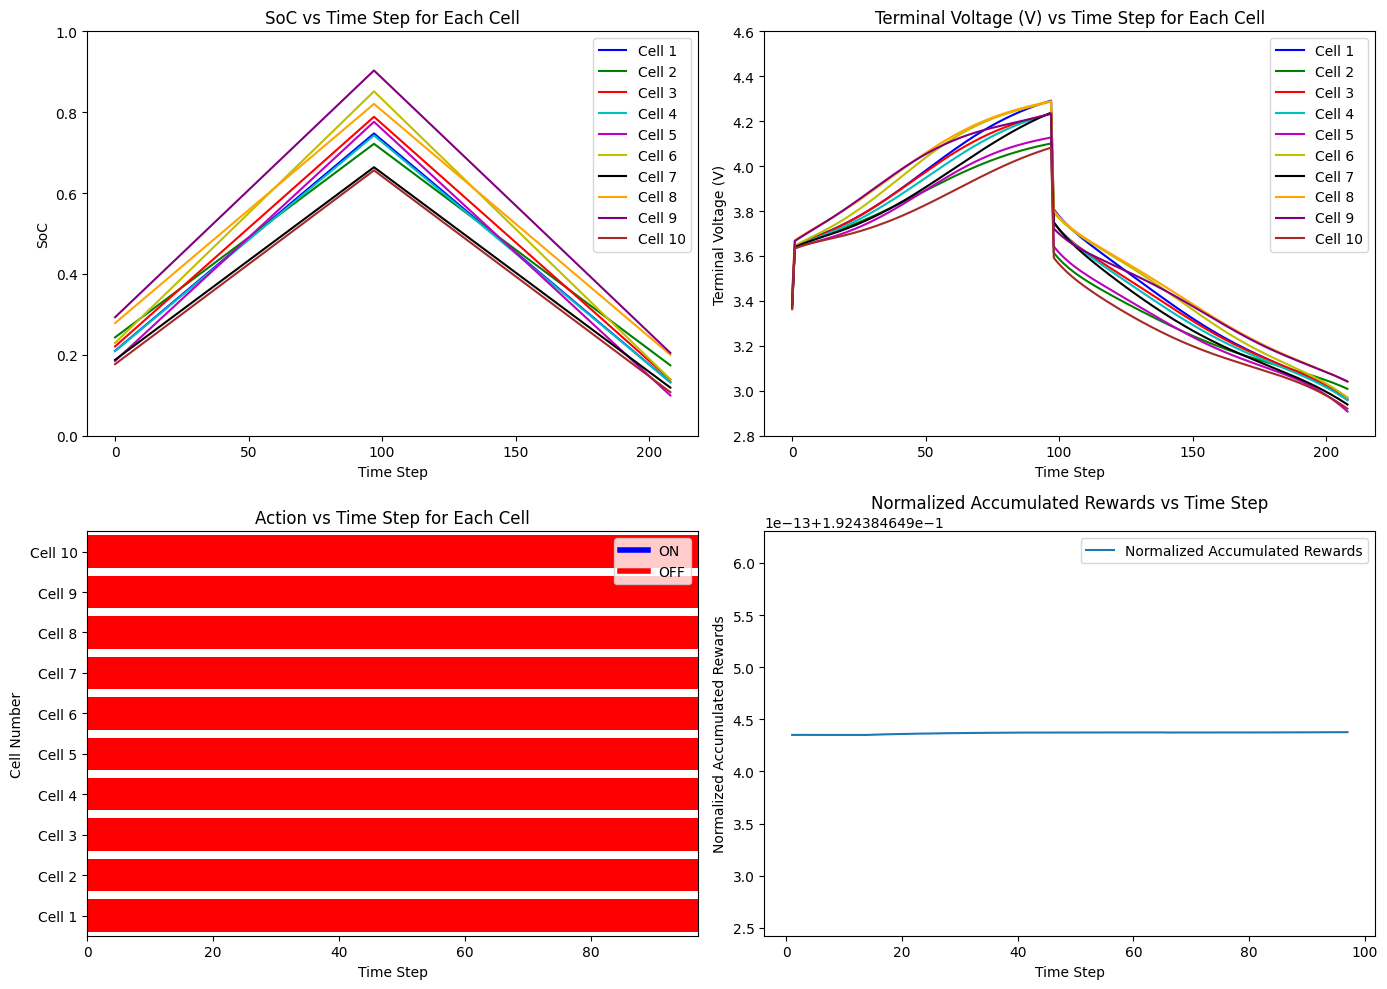

In [154]:
plot_bms_evolution(bms, states_soc_1, states_voltage_1, actions_1, rewards_1, dones_1)

# Always connected (All the batteries Discharge)

In [8]:
bms.reset(seed = 0)
states_soc_2 = [bms.state[:num_cells]]
states_voltage_2 = [bms.state[num_cells:]]
actions_2 = []
rewards_2 = []
dones_2 = [False]

while not dones_2[-1] and len(states_soc_2) < T:
    action = [1 for _ in range(num_cells)]
    actions_2.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_2.append(state[:num_cells])
    states_voltage_2.append(state[num_cells:])
    rewards_2.append(reward)
    dones_2.append(done)

print(f"Sum of rewards: {np.sum(rewards_2)}")

charge_end_2 = len(states_soc_2)
mean_capacity_2 = np.mean(states_soc_2[-1])
min_capacity_2 = np.min(states_soc_2[-1])
actions_2 = np.array(actions_2)
mismatches_2 = sum([np.sum(actions_2[i] != actions_2[i+1]) for i in range(len(actions_2) - 1)])


while states_soc_2[-1].min() > 0.1:
    bms.discharge()
    states_soc_2.append(bms.state[:num_cells])
    states_voltage_2.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_2}")
print(f"Length of discharge: {len(states_soc_2) - charge_end_2}")
print(f"Total length: {len(states_soc_2)}")
print(f"Mean capacity: {np.round(mean_capacity_2, 3)}")
print(f"Min capacity: {np.round(min_capacity_2, 3)}")
print(f"Number of mismatches: {mismatches_2}")



Sum of rewards: 94.12579754199037
Length of charge: 226
Length of discharge: 115
Total length: 341
Mean capacity: 0.775
Min capacity: 0.674
Number of mismatches: 0


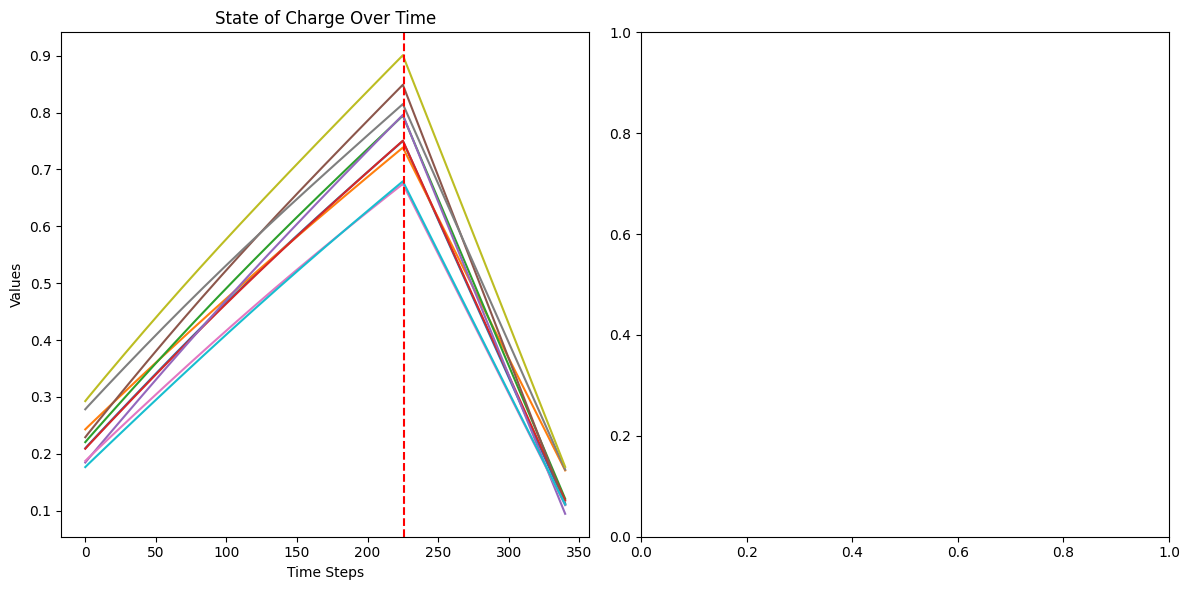

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_2, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_2, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_2, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_2, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap
#

# Random Controller

In [10]:
bms.reset(seed = 0)
states_soc_3 = [bms.state[:num_cells]]
states_voltage_3 = [bms.state[num_cells:]]
actions_3 = []
rewards_3 = []
dones_3 = [False]

while not dones_3[-1] and len(states_soc_3) < T:
    action = [np.random.randint(0, 2) for _ in range(num_cells)]
    # print('action', action)
    # print('\n')
    actions_3.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_3.append(state[:num_cells])
    states_voltage_3.append(state[num_cells:])
    rewards_3.append(reward)
    dones_3.append(done)

print(f"Sum of rewards: {np.sum(rewards_3)}")

charge_end_3 = len(states_soc_3)
mean_capacity_3 = np.mean(states_soc_3[-1])
min_capacity_3 = np.min(states_soc_3[-1])
actions_3 = np.array(actions_3)
mismatches_3 = sum([np.sum(actions_3[i] != actions_3[i+1]) for i in range(len(actions_3) - 1)])




while states_soc_3[-1].min() > 0.1:
    bms.discharge()
    states_soc_3.append(bms.state[:num_cells])
    states_voltage_3.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_3}")
print(f"Length of discharge: {len(states_soc_3) - charge_end_3}")
print(f"Total length: {len(states_soc_3)}")
print(f"Mean capacity: {np.round(mean_capacity_3, 3)}")
print(f"Min capacity: {np.round(min_capacity_3, 3)}")
print(f"Number of mismatches: {mismatches_3}")



Sum of rewards: 56.39828187058413
Length of charge: 145
Length of discharge: 121
Total length: 266
Mean capacity: 0.799
Min capacity: 0.696
Number of mismatches: 720


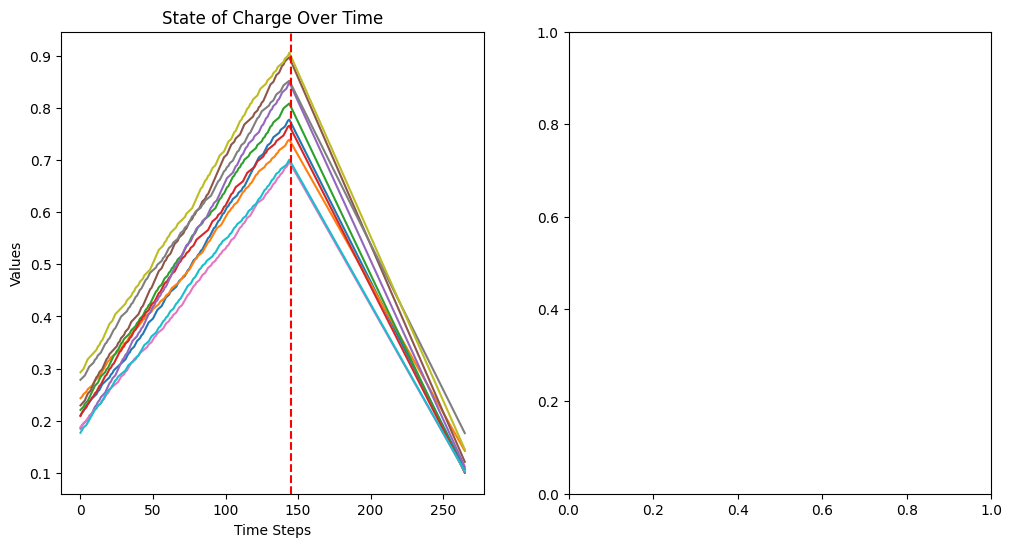

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_3, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_3, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_3, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_3, color='r', linestyle='--', label='Charge End')

# plt.tight_layout()  # Adjust layout to prevent overlap


# Rule-Based


In [149]:
bms.reset(seed = 0)
states_soc_4 = [bms.state[:num_cells]]
states_voltage_4 = [bms.state[num_cells:]]
actions_4 = []
rewards_4 = []
dones_4 = [False]

while not dones_4[-1] and len(states_soc_4) < T:
    median_soc = np.median(states_soc_4[-1])
    action = [1 if soc > (states_soc_4[-1].min() + 0.04) else 0 for soc in states_soc_4[-1]]
    actions_4.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_4.append(state[:num_cells])
    states_voltage_4.append(state[num_cells:])
    rewards_4.append(reward)
    dones_4.append(done)

print(f"Sum of rewards: {np.sum(rewards_4)}")

charge_end_4 = len(states_soc_4)
mean_capacity_4 = np.mean(states_soc_4[-1])
min_capacity_4 = np.min(states_soc_4[-1])
actions_4 = np.array(actions_4)
stds_4 = np.std(states_soc_4[-1])
mismatches_4 = sum([np.sum(actions_4[i] != actions_4[i+1]) for i in range(len(actions_4) - 1)])




while states_soc_4[-1].min() > 0.1:
    bms.discharge()
    states_soc_4.append(bms.state[:num_cells])
    states_voltage_4.append(bms.state[num_cells:])


data = {
    "Length of charge": [charge_end_4],
    "Length of discharge": [len(states_soc_4) - charge_end_4],
    "Total length": [len(states_soc_4)],
    "Standard Deviation": [stds_4],
    "Mean capacity": [np.round(mean_capacity_4, 3)],
    "Min capacity": [np.round(min_capacity_4, 3)],
    "Number of switches": [mismatches_4]
}

df = pd.DataFrame(data)
np.round(df, 4).T


Sum of rewards: 43.12875326170959


,0
Length of charge,140.0000
Length of discharge,126.0000
Total length,266.0000
Standard Deviation,0.0145
Mean capacity,0.8960
Min capacity,0.8640
Number of switches,472.0000


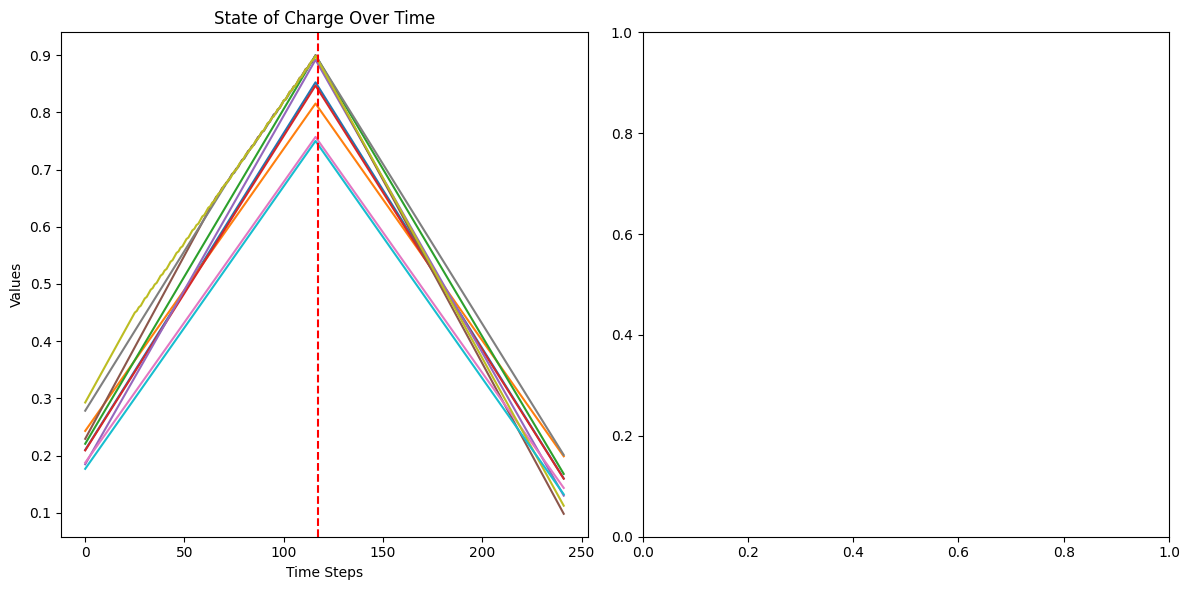

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_4, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_4, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_4, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_4, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap


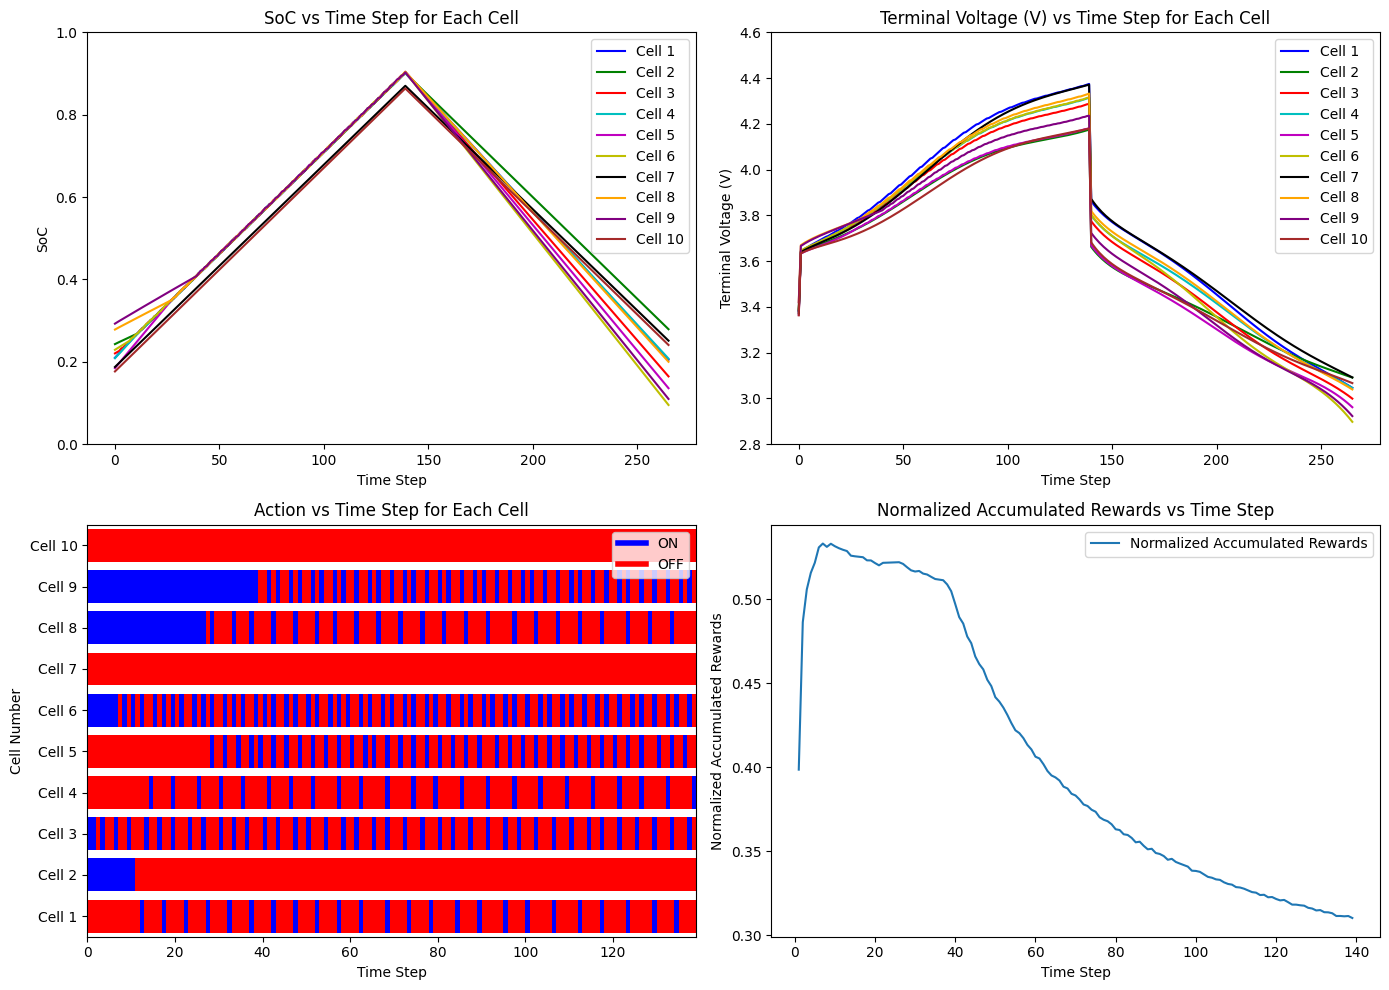

In [150]:
plot_bms_evolution(bms, states_soc_4, states_voltage_4, actions_4, rewards_4, dones_4)

# Q Learning (Efficient)

In [156]:
bins = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


In [157]:
init_Q_value = -0.1
Q = defaultdict(lambda: init_Q_value)

In [160]:
num_episodes = 100_000

memory_threshold = init_Q_value

for episode in range(num_episodes):

    if episode == num_episodes - 5:
        bms.reset(seed =0)
    else:
        bms.reset()
        
    states_soc_6 = [bms.state[:num_cells]]
    states_voltage_6 = [bms.state[num_cells:]]
    actions_6 = []
    rewards_6 = []
    dones_6 = [False]
    random_actions_6 = []
    actions_int_6 = []
    states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

    epsilon = 0.1
    stepsize = 0.1
    gamma = 0.99

    if episode  >= num_episodes - 10_000:
        epsilon = 0.0

    while not dones_6[-1] and len(states_soc_6) < T:

        # if len(dones_6) % 1000 == 0:
        #     print('\n')
        #     print(f"Episode: {episode + 1}")
        #     print(f"Timesteps: {len(dones_6)}")
        #     print(f"Memory Threshold:" , memory_threshold)
        #     print(f"Number of unique (state, action) pairs: {len(Q)}")

        state_int = tuple(discretize_features(states_soc_6[-1], bins))

        if np.random.uniform(0, 1) < epsilon:
            random_actions_6.append(True)
            action = bms.action_space.sample()
        else:
            random_actions_6.append(False)
            # Collect all actions with non-zero Q-values for the current state
            state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

            if state_actions:
                max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
                max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
                action_int = random.choice(max_actions)
                action = np.array(action_int)
                if max_q_value < init_Q_value:
                    action = bms.action_space.sample()
                    random_actions_6[-1] = True
            else:
                action = bms.action_space.sample()
                random_actions_6[-1] = True

        action_int = tuple(action)
        actions_int_6.append(action_int)

        state, reward, done, _, _ = bms.step(action)
        state_soc = state[:num_cells]
        state_voltage = state[num_cells:]
        states_soc_6.append(state_soc)
        states_voltage_6.append(state_voltage)
        actions_6.append(action)
        rewards_6.append(reward)
        dones_6.append(done)

        if not done:
            next_state_int = tuple(discretize_features(state_soc, bins))
            states_int_6.append(next_state_int)
            next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
            if next_state_actions:
                max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
            else:
                max_next_q_value = init_Q_value

            if (state_int, action_int) not in Q:
                Q[(state_int, action_int)] = init_Q_value

            Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
                reward + gamma * max_next_q_value - Q[(state_int, action_int)]
            )

        # Remove entries with Q-values less than 0.0
        Q = {k: v for k, v in Q.items() if v >= memory_threshold}
        
        if len(Q) > 1500:
            memory_threshold/=1.1
        if len(Q) < 500 and (np.abs(memory_threshold) < 100):
            memory_threshold*=1.1



    if episode % 1 == 0:
        print('\n\n')
        print(f"Episode: {episode + 1}")
        print(f"Sum of rewards: {np.sum(rewards_6)}")
        print(f"Timesteps: {len(dones_6)}")
        print(f"Number of states visited: {len(set(states_int_6))}")
        print(f"Number of random actions: {sum(random_actions_6)}")
        print(f"Number of unique (state, action) pairs: {len(Q)}")

charge_end_6 = len(states_soc_6)
mean_capacity_6 = np.mean(states_soc_6[-1])
min_capacity_6 = np.min(states_soc_6[-1])
actions_6 = np.array(actions_6)
stds_6 = np.std(states_soc_6[-1])
mismatches_6 = sum([np.sum(actions_6[i] != actions_6[i+1]) for i in range(len(actions_6) - 1)])


while states_soc_6[-1].min() > 0.1:
    bms.discharge()
    states_soc_6.append(bms.state[:num_cells])
    states_voltage_6.append(bms.state[num_cells:])

print(f"\n\n\nLength of charge: {charge_end_6}")
print(f"Length of discharge: {len(states_soc_6) - charge_end_6}")
print(f"Total length: {len(states_soc_6)}")
print(f"Mean capacity: {np.round(mean_capacity_6, 3)}")
print(f"Min capacity: {np.round(min_capacity_6, 3)}")
print(f"Standard Deviation: {np.round(stds_6, 3)}")
print(f"Number of switches: {mismatches_6}")




Episode: 1
Sum of rewards: 39.067392332143385
Timesteps: 155
Number of states visited: 55
Number of random actions: 74
Number of unique (state, action) pairs: 1460



Episode: 2
Sum of rewards: 34.89441930603714
Timesteps: 159
Number of states visited: 60
Number of random actions: 82
Number of unique (state, action) pairs: 1496



Episode: 3
Sum of rewards: 30.039034332061004
Timesteps: 144
Number of states visited: 48
Number of random actions: 85
Number of unique (state, action) pairs: 1497



Episode: 4
Sum of rewards: 36.90538949843719
Timesteps: 154
Number of states visited: 52
Number of random actions: 112
Number of unique (state, action) pairs: 1489



Episode: 5
Sum of rewards: 29.015924412037904
Timesteps: 166
Number of states visited: 55
Number of random actions: 139
Number of unique (state, action) pairs: 1499



Episode: 6
Sum of rewards: 29.315780315898294
Timesteps: 158
Number of states visited: 55
Number of random actions: 138
Number of unique (state, action) pairs: 14

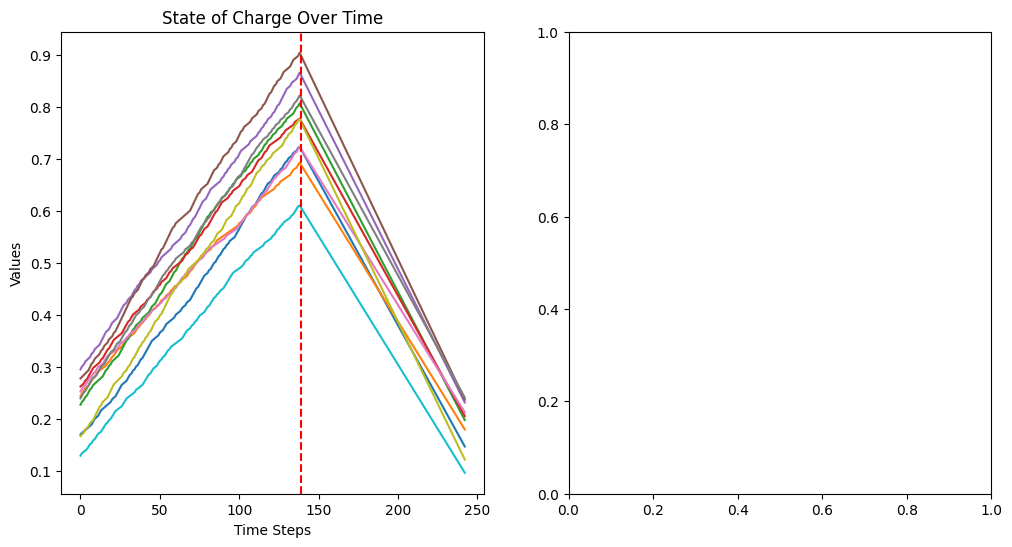

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_6, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_6, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_6, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_6, color='r', linestyle='--', label='Charge End')

# plt.tight_layout()  # Adjust layout to prevent overlap


# PPO

In [42]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [43]:
model = PPO("MlpPolicy", bms,  verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [44]:
from stable_baselines3.common.callbacks import BaseCallback

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.variances = []
        self.mean_capacities = []
        self.min_capacities = []
        self.episode_count = 0
        self.previous_action = None
        self.mismatches = 0
        self.total_differences = 0
        self.episode_differences = []
    
    def _on_step(self) -> bool:
        # Check if the episode is done
        if self.locals['dones'][0]:
            # Calculate the variance of the state
            terminal_soc = self.locals['infos'][0]['terminal_observation'][:num_cells]
            state_variance = np.var(terminal_soc)
            mean_capacity = np.mean(terminal_soc)
            min_capacity = np.min(terminal_soc)

            self.variances.append(state_variance)
            self.mean_capacities.append(mean_capacity)
            self.min_capacities.append(min_capacity)
            self.episode_count += 1
            
            # Append the total differences of this episode to the list
            self.episode_differences.append(self.total_differences)
            self.total_differences = 0  # Reset for the next episode

            # Print average variance and average differences every 5 episodes
            if self.episode_count % 20 == 0:
                average_variance = np.mean(self.variances)
                average_mean_capacity = np.mean(self.mean_capacities)
                average_min_capacity = np.mean(self.min_capacities)
                average_differences = np.mean(self.episode_differences)
                print('\n')
                print(f"Average State Variance after {self.episode_count} episodes: {average_variance:.3f}")
                print(f"Mean capacity after {self.episode_count} episodes: {average_mean_capacity:.3f}")
                print(f"Min capacity after {self.episode_count} episodes: {average_min_capacity:.3f}")
                print(f"Average Action Differences after {self.episode_count} episodes: {average_differences:.3f}")
                self.variances = []  # Reset the list to start collecting for the next batch of episodes
                self.episode_differences = []  # Reset the differences list

        # Track mismatches in actions
        current_action = self.locals['actions']
        if self.previous_action is not None:
            # Calculate the number of different action components
            action_differences = np.sum(self.previous_action != current_action)
            self.total_differences += action_differences

        # Update the previous action
        self.previous_action = current_action

        return True


In [45]:
model.save("ppo_bms")

In [78]:
bms.var_weight = 0.0
bms.max_min_weight =.70
bms.switch_weight = 0.30

In [79]:
print(bms.var_weight, bms.max_min_weight, bms.switch_weight)

0.0 0.7 0.3


In [80]:
model.save("ppo_bms")
model = PPO.load("ppo_bms", env=bms)
model.learning_rate = 0.0001
model.save("ppo_bms")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [81]:
model = PPO.load("ppo_bms", env=bms)
model.learn(total_timesteps= 15_000_0, callback=CustomCallback())
model.save("ppo_bms")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 233      |
|    ep_rew_mean     | 92.3     |
| time/              |          |
|    fps             | 639      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 232         |
|    ep_rew_mean          | 91.1        |
| time/                   |             |
|    fps                  | 549         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.028374646 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22    

In [128]:
model = PPO.load("ppo_bms")

bms.reset(seed = 0)
states_soc_5 = [bms.state[:num_cells]]
states_voltage_5 = [bms.state[num_cells:]]
actions_5 = []
rewards_5 = []
dones_5 = [False]

state = bms.state.copy()
while not dones_5[-1] and len(states_soc_5) < T:
    state_1 = state.copy()


    action, _ = model.predict(state, deterministic= False)
    actions_5.append(action)
    state, reward, done, _, _ = bms.step(action)
    state_2 = state.copy()
    states_soc_5.append(state[:num_cells])
    states_voltage_5.append(state[num_cells:])
    rewards_5.append(reward)
    dones_5.append(done)

print(f"Sum of rewards: {np.sum(rewards_5)}")

charge_end_5 = len(states_soc_5)
mean_capacity_5 = np.mean(states_soc_5[-1])
min_capacity_5 = np.min(states_soc_5[-1])
actions_5 = np.array(actions_5)
stds_5 = np.std(states_soc_5[-1])
mismatches_5 = sum([np.sum(actions_5[i] != actions_5[i+1]) for i in range(len(actions_5) - 1)])



while states_soc_5[-1].min() > 0.1:
    bms.discharge()
    states_soc_5.append(bms.state[:num_cells])
    states_voltage_5.append(bms.state[num_cells:])


import pandas as pd

data = {
    "Length of charge": [charge_end_5],
    "Length of discharge": [len(states_soc_5) - charge_end_5],
    "Total length": [len(states_soc_5)],
    "Standard Deviation": [stds_5],
    "Mean capacity": [np.round(mean_capacity_5, 3)],
    "Min capacity": [np.round(min_capacity_5, 3)],
    "Number of switches": [mismatches_5]
}

df = pd.DataFrame(data)
np.round(df, 4).T



Sum of rewards: 83.83811598365574


,0
Length of charge,226.0000
Length of discharge,120.0000
Total length,346.0000
Standard Deviation,0.0117
Mean capacity,0.8750
Min capacity,0.8620
Number of switches,125.0000


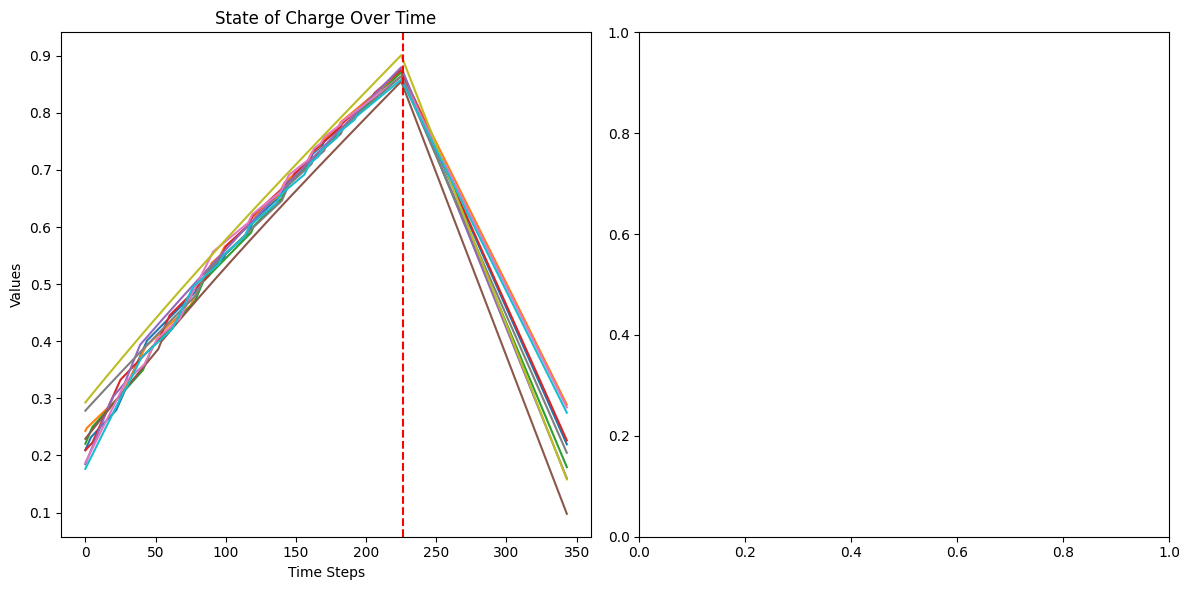

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_5, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_5, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_5, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_5, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap


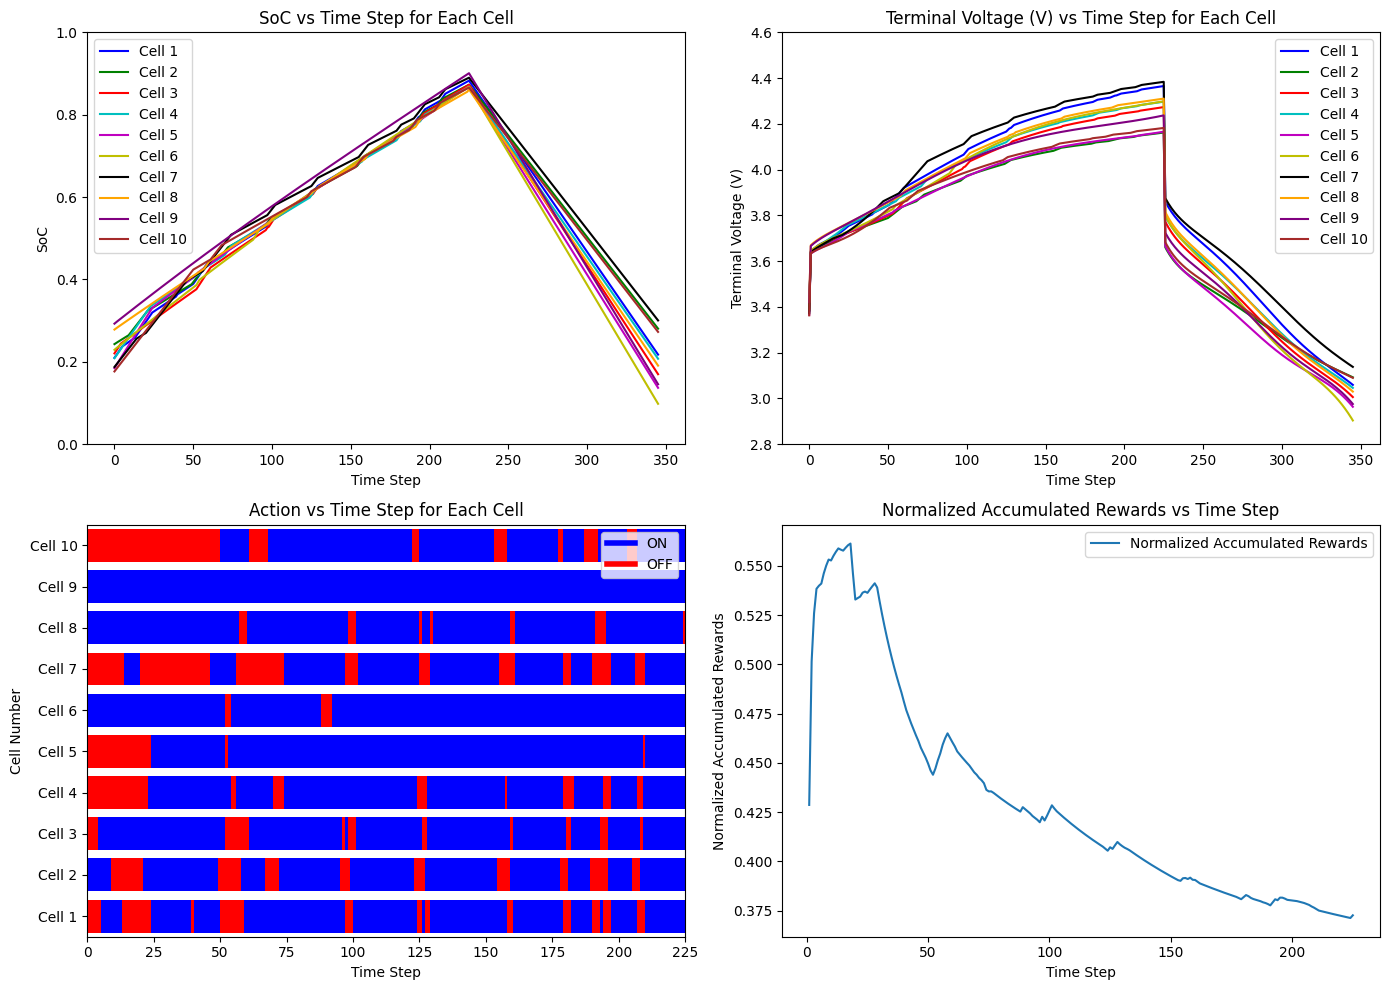

In [129]:
plot_bms_evolution(bms, states_soc_5, states_voltage_5, actions_5, rewards_5, dones_5, include_bad_rewards=False)
    

In [104]:
print(f"Length of charge: {charge_end_1}")
print(f"Length of charge: {charge_end_2}")
print(f"Length of charge: {charge_end_3}")
print(f"Length of charge: {charge_end_4}")
print(f"Length of charge: {charge_end_6}")
print(f"Length of charge: {charge_end_5}")


Length of charge: 98
Length of charge: 226
Length of charge: 145
Length of charge: 138


NameError: name 'charge_end_6' is not defined

In [ ]:
print(f"Length of discharge: {len(states_soc_1) - charge_end_1}")
print(f"Length of discharge: {len(states_soc_2) - charge_end_2}")
print(f"Length of discharge: {len(states_soc_3) - charge_end_3}")
print(f"Length of discharge: {len(states_soc_4) - charge_end_4}")
print(f"Length of discharge: {len(states_soc_6) - charge_end_6}")
print(f"Length of discharge: {len(states_soc_5) - charge_end_5}")

Length of discharge: 18
Length of discharge: 122
Length of discharge: 120
Length of discharge: 124
Length of discharge: 90
Length of discharge: 95


In [ ]:
print(f"Total length: {len(states_soc_1)}")
print(f"Total length: {len(states_soc_2)}")
print(f"Total length: {len(states_soc_3)}")
print(f"Total length: {len(states_soc_4)}")
print(f"Total length: {len(states_soc_6)}")
print(f"Total length: {len(states_soc_5)}")

Total length: 23
Total length: 377
Total length: 267
Total length: 247
Total length: 222
Total length: 240


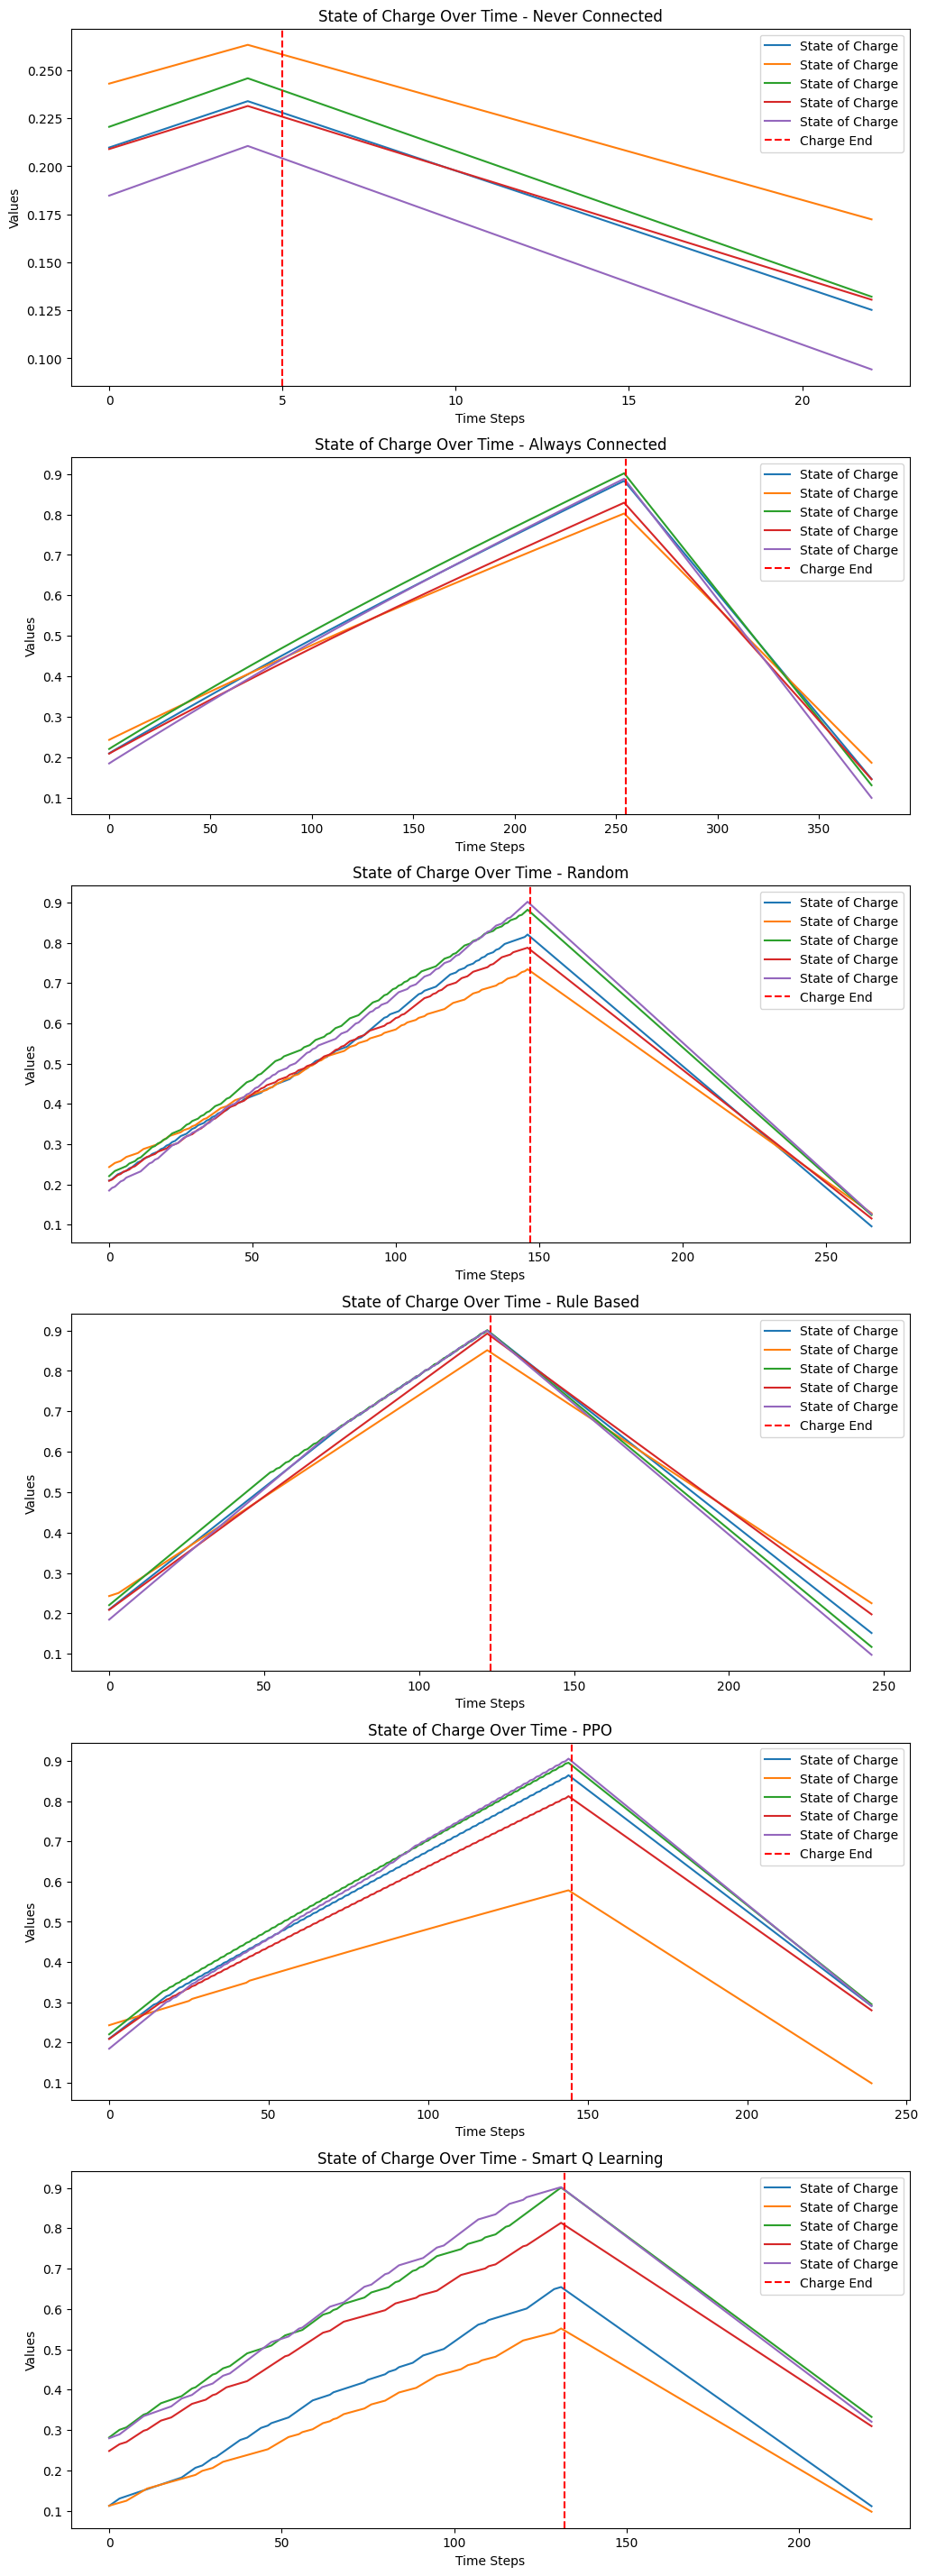

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(12, 36))  # Create a figure with 6 rows and 1 column

titles = ['Never Connected', 'Always Connected', 'Random', 'Rule Based', 'PPO', 'Smart Q Learning']
states = [states_soc_1, states_soc_2, states_soc_3, states_soc_4, states_soc_5, states_soc_6]
charge_ends = [charge_end_1, charge_end_2, charge_end_3, charge_end_4, charge_end_5, charge_end_6]

for i, ax in enumerate(axs):
    ax.plot(states[i], label='State of Charge')
    ax.set_title(f'State of Charge Over Time - {titles[i]}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Values')
    ax.axvline(x=charge_ends[i], color='r', linestyle='--', label='Charge End')
    ax.legend()

